In [1]:
import os
os.chdir("../")
%pwd

'c:\\Users\\atanu\\Documents\\models\\hair_color_try_on'

In [2]:
import time
import numpy as np
import torch
import onnx
import onnxruntime
from hair_segmentation.model import UNet
from PIL import Image
import matplotlib.pyplot as plt

In [3]:
hair_seg_model_path = "saved_models/hair_seg_model.pth"
save_dir = "saved_models"
os.makedirs(save_dir, exist_ok=True) 
onnx_path = os.path.join(save_dir, "hair_seg_model.onnx")

torch_model = UNet()
torch_model.load_state_dict(torch.load(hair_seg_model_path, weights_only=True, map_location='cpu'))
torch_model.eval()

dummy_input = torch.randn(1, 3, 256, 256, requires_grad=True)

torch.onnx.export(
    torch_model, 
    dummy_input, 
    onnx_path, 
    export_params=True, 
    opset_version=11,  
    do_constant_folding=True,
    input_names=["input"],  
    output_names=["output"], 
    dynamic_axes={"input": {0: "batch_size"}, "output": {0: "batch_size"}} 
)

In [4]:
onnx_model = onnx.load(onnx_path)
onnx.checker.check_model(onnx_model)

In [5]:
ort_session = onnxruntime.InferenceSession(onnx_path, providers=["CPUExecutionProvider"])

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

# compute ONNX Runtime output prediction
ort_inputs = {"input": to_numpy(dummy_input)}
ort_output = ort_session.run(None, ort_inputs)

# compare ONNX Runtime and PyTorch results
torch_output = torch_model(dummy_input)
np.testing.assert_allclose(to_numpy(torch_output), ort_output[0], rtol=1e-03, atol=1e-05)

print("Exported model has been tested with ONNXRuntime, and the result looks good!")

Exported model has been tested with ONNXRuntime, and the result looks good!


### torch vs onnx

In [6]:
start = time.time()
torch_output = torch_model(dummy_input)
end = time.time()
print(f"Inference of Pytorch model used {end - start} seconds")

ort_inputs = {'input': to_numpy(dummy_input)}
start = time.time()
ort_outs = ort_session.run(None, ort_inputs)
end = time.time()
print(f"Inference of ONNX model used {end - start} seconds")

Inference of Pytorch model used 0.47780847549438477 seconds
Inference of ONNX model used 0.4012570381164551 seconds


## Test Onnxruntime for sample image

In [7]:
image = Image.open("images/003.jpg").convert("RGB")
image = image.resize((256, 256))

image = np.array(image, dtype=np.float32) / 255.0  # Normalize

# Transpose to (C, H, W)
image = np.transpose(image, (2, 0, 1))

# Add batch dimension
tensor = np.expand_dims(image, axis=0)

print("Tensor Shape:", tensor.shape)

Tensor Shape: (1, 3, 256, 256)


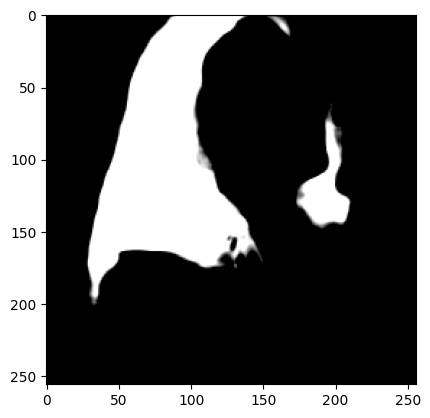

In [8]:
ort_session = onnxruntime.InferenceSession(onnx_path, providers=["CPUExecutionProvider"])

ort_inputs = {'input': tensor}

outputs = ort_session.run(None, ort_inputs)

output_image = outputs[0][0]

out = Image.fromarray(np.uint8((output_image * 255.0).clip(0, 255)[0]), mode='L')

plt.imshow(out, cmap='gray')
plt.show()